In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
from skimage import measure, segmentation
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from scipy.ndimage import zoom
from skimage.morphology import skeletonize, skeletonize_3d
from skimage import filters, morphology

from scipy.ndimage.filters import convolve, correlate
from scipy import signal

from skimage.filters import frangi, sato

from PIL import Image

In [2]:
source_dir = './data/'
files = list(sorted(glob.glob(source_dir + '/*/*.raw')))
list(enumerate(files))

[(0, './data/P01/P01_60um_1612x623x1108.raw'),
 (1, './data/P02/P02_60um_1387x778x1149.raw'),
 (2, './data/P03/P03_60um_1473x1163x1148.raw'),
 (3, './data/P04/P04_60um_1273x466x1045.raw'),
 (4, './data/P05/P05_60um_1454x817x1102.raw'),
 (5, './data/P06/P06_60um_1425x564x1028.raw'),
 (6, './data/P07/P7_60um_1216x692x926.raw'),
 (7, './data/P08/P08_60um_1728x927x1149.raw'),
 (8, './data/P09/P09_60um_1359x456x1040.raw'),
 (9, './data/P10/P10_60um_1339x537x1035.raw'),
 (10, './data/P11/P11_60um_1735x595x1150.raw'),
 (11, './data/P12/P12_60um_1333x443x864.raw'),
 (12, './data/P13/P13_60um_1132x488x877.raw')]

In [177]:
%%time
volume = load_volume(files[11], scale=0.5)
print(volume.shape)
# volume = volume[0:300, 0:300, 0:300]
VolumeVisualizer(volume, binary=False).visualize()

(432, 222, 666)
CPU times: user 13.2 s, sys: 4.02 s, total: 17.2 s
Wall time: 7min 40s


## applying frangi filter

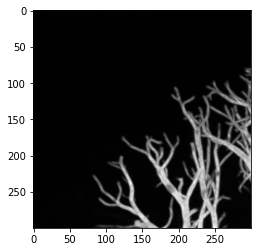

In [168]:
projection = np.max(volume, axis=1)
plt.imshow(projection, cmap='gray')

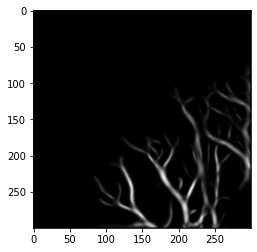

In [176]:
projection_frangi = frangi(
    projection,
    sigmas=[1, 3, 5],
    alpha=0.0001,
    beta=0.5,
    gamma=0.5,
    black_ridges=False
)

plt.imshow(projection_frangi, cmap='gray')

In [170]:
%%time
filtered = frangi(
    volume,
    sigmas=[5],
    alpha=0.0001,
    beta=0.5,
    gamma=0.06,
    black_ridges=False
)

CPU times: user 1min 5s, sys: 21.9 s, total: 1min 27s
Wall time: 1min 57s


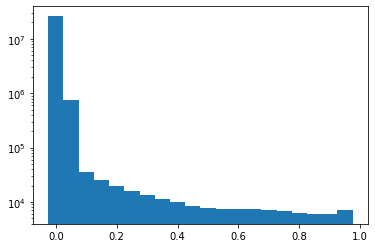

In [171]:
bins, edges = np.histogram(filtered, bins=20)
plt.bar(edges[:-1], bins, width=0.05)
plt.yscale('log')

In [172]:
base_tree = (volume > 70).astype(np.uint8)
frangis = (filtered > 0.8).astype(np.uint8) * 2
frangis[base_tree > 0] = 0

xdd = base_tree + frangis

ColorMapVisualizer(xdd).visualize()

## simple threshold segmentation

In [27]:
import skimage
skimage.__version__

'0.16.2'

In [19]:
threshold = 70
mask_raw = volume > threshold

VolumeVisualizer(mask_raw).visualize()

In [24]:
%%time
mask_frangi = frangi(mask_raw, black_ridges=False, scale_range=(15, 20), )

CPU times: user 48.4 s, sys: 2.05 s, total: 50.5 s
Wall time: 51.3 s


In [25]:
mask_frangi.max()

0.0002299133975160598

In [26]:
VolumeVisualizer(mask_frangi * 500_000, binary=False).visualize()

In [5]:
def get_main_regions(binary_mask, min_size=10_000, connectivity=3):
    labeled = measure.label(binary_mask, connectivity=connectivity)
    region_props = measure.regionprops(labeled)
    
    main_regions_masks = []
    
    for props in region_props:
        if props.area >= min_size:
            main_regions_masks.append((props.filled_image, props.bbox))
            
    return main_regions_masks

def merge_masks(masks, img_shape):
    result_mask = np.zeros(img_shape, dtype=np.uint8)
    for mask, bbox in masks:
        min1, min2, min3, max1, max2, max3 = bbox
        result_mask[min1:max1, min2:max2, min3:max3] += mask.astype(np.uint8)
        
    return result_mask

In [6]:
%%time
main_regions_masks = get_main_regions(mask_raw, min_size=5_000, connectivity=1)

CPU times: user 8.79 s, sys: 304 ms, total: 9.1 s
Wall time: 9.1 s


In [7]:
mask = main_regions_masks[0][0]
# VolumeVisualizer(mask).visualize()

## utility functions

In [24]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere

def convolve_with_ball(mask, ball_radius, dtype=np.uint16):
    kernel = spherical_kernel(ball_radius, filled=True)
    return signal.convolve(mask.astype(dtype), kernel.astype(dtype), mode='same')

def get_arterial_regions(conv_img, lower_hyst_fraction, upper_hyst_fraction):
    lower_hyst_value = lower_hyst_fraction * conv_img.max()
    upper_hyst_value = upper_hyst_fraction * conv_img.max()
    return filters.apply_hysteresis_threshold(conv_img, lower_hyst_value, upper_hyst_value)

def reconstruct_from_skeleton(skeleton, ball_radius):    
    mask = np.zeros(skeleton.shape, dtype=np.uint8)
    mask = np.pad(mask, ball_radius)
    
    kernel = spherical_kernel(ball_radius, filled=True)
    central_points = np.argwhere(skeleton == 1)
    
    for central_point in central_points:
        start_corner = tuple(central_point)
        end_corner = tuple(central_point + 2*ball_radius + 1)
        
        start1, start2, start3 = start_corner
        end1, end2, end3 = end_corner
        
        mask_slice = mask[start1:end1, start2:end2, start3:end3]
        mask_slice[:] = np.logical_or(mask_slice, kernel)
                
    return mask[ball_radius:-ball_radius, ball_radius:-ball_radius, ball_radius:-ball_radius]

# high level functions

def get_tree_core(tree_mask, kernel_radius, max_fraction):
    convolved_mask = convolve_with_ball(tree_mask, kernel_radius)
    core_voxels = convolved_mask > max_fraction * convolved_mask.max()
    core_skeleton = skeletonize_3d(core_voxels.astype(np.uint8))
    core_reconstruction = reconstruct_from_skeleton(core_skeleton, kernel_radius)
    
    return core_reconstruction

def expand_tree_reconstruction(tree_mask, reconstruction, kernel_radius, max_fraction):
    convolved_mask = convolve_with_ball(tree_mask, kernel_radius)
    
    kernel_vol = spherical_kernel(kernel_radius).sum()
    threshold_value = int(max_fraction * kernel_vol)
    
    # set current reconstruction to infinity
    convolved_mask_with_huge_core = convolved_mask + reconstruction * (kernel_vol + 2)
        
        
    expanded_rec = filters.apply_hysteresis_threshold(convolved_mask_with_huge_core, threshold_value, kernel_vol + 5)
    expansion = expanded_rec - reconstruction
    
    convolved_mask_with_huge_expansion = convolved_mask + expansion * (kernel_vol + 2)
    expanded_expansion = filters.apply_hysteresis_threshold(convolved_mask_with_huge_expansion, threshold_value, kernel_vol + 5)
    
    ee_skeleton = skeletonize_3d(expanded_expansion.astype(np.uint8))
    ee_reconstruction = reconstruct_from_skeleton(ee_skeleton, kernel_radius)
    
    return ee_reconstruction, ee_skeleton

In [9]:
%%time
core_rec = get_tree_core(mask, 15, 0.95)
# VolumeVisualizer(np.logical_or(core_rec, mask)).visualize()
VolumeVisualizer(core_rec).visualize()

CPU times: user 8.91 s, sys: 2.17 s, total: 11.1 s
Wall time: 12.7 s


In [10]:
%%time
ee = expand_tree_reconstruction(mask, core_rec, kernel_radius=10, max_fraction=0.8)
VolumeVisualizer(ee).visualize()

CPU times: user 11.6 s, sys: 2.22 s, total: 13.8 s
Wall time: 15.9 s


In [25]:
%%time

total_skel = np.zeros(mask.shape)
rec = get_tree_core(mask, 15, 0.95)
total_rec = rec.copy().astype(np.uint8)
new_rec = rec.copy()
print('core is nice')

for i, kernel_radius in enumerate([10, 8, 7, 6, 5, 4, 3, 2, 1]):
    new_rec, new_ee_skel = expand_tree_reconstruction(mask, new_rec, kernel_radius=kernel_radius, max_fraction=0.5)
    rec = np.logical_or(rec, new_rec).astype(np.uint8)
    
    total_skel = np.logical_or(total_skel, new_ee_skel).astype(np.uint8)
    
    just_expansion = new_rec.copy()
    just_expansion[total_rec > 0] = 0
    total_rec += just_expansion * (i + 2)
    
    print('iter for', kernel_radius, 'ended successfully XD')
    

core is nice
iter for 10 ended successfully XD
iter for 8 ended successfully XD
iter for 7 ended successfully XD
iter for 6 ended successfully XD
iter for 5 ended successfully XD
iter for 4 ended successfully XD
iter for 3 ended successfully XD
iter for 2 ended successfully XD
iter for 1 ended successfully XD
CPU times: user 1min 51s, sys: 19.7 s, total: 2min 10s
Wall time: 2min 11s


In [14]:
VolumeVisualizer(rec).visualize()

In [15]:
ColorMapVisualizer(total_rec).visualize(interactive=False)

In [18]:
ColorMapVisualizer(mask + total_rec).visualize(interactive=True)

In [30]:
VolumeVisualizer(total_skel).visualize()

In [17]:
reconstruction_skeleton = skeletonize_3d(rec)
VolumeVisualizer(reconstruction_skeleton).visualize()

In [ ]:
mask_with_no_skeleton = mask.copy()
mask_with_no_skeleton[reconstruction_skeleton == 1] = 0

VolumeVisualizer(reconstruction_skeleton.astype(np.uint8) * 2 + mask_with_no_skeleton, binary=False).visualize(primary_color=(1,1,1))

In [17]:
VolumeVisualizer(reconstruction_skeleton).visualize()

In [18]:
mask_skel = skeletonize_3d(mask.astype(np.uint8))

mask_with_no_skeleton = mask.copy()
mask_with_no_skeleton[mask_skel == 1] = 0

VolumeVisualizer(mask_skel.astype(np.uint8) * 2 + mask_with_no_skeleton, binary=False).visualize(primary_color=(1,1,1))